# Búsqueda de Hiperparámetros

Las redes neuronales tienen decenas de hiperparámetros que afectan su arquitectura y proceso de entrenamiento. Más aún, el desempeño final del modelo está condicionado a encontar un conjunto de valores para dichos hiperparámetros exitosos, para una inicialización aleatoria de los pesos dada. Por ello, la exploración de hiperparámetros se vuelve una de las partes más tediosas y críticas del entrenamiento de redes neuronales. Para obtener resultados que sean correctos, significativos, y reproducibles, es necesario planificar y sistemizar este proceso de búsqueda.

>  Hyper-parameter optimization should be regarded as a formal outer loop in the learning process.

Formalmente, este proceso se puede describir como la minimización de la función de pérdida (o la maximización de la performance) como si fuera una función de *caja negra* que toma como parámetros los valores de los hiperparámetros:

$$ f(\theta) = loss_\theta(y, \hat{y}) $$
$$ \theta^* = argmin_\theta f(\theta) $$

donde $\theta$ es el conjunto de hiperparámetros del modelo, $loss$ es la pérdida generada entre las etiquetas verdaderas $y$, y las etiquetas generadas por el modelo $\hat{y}$, y $f$ es la función objetivo de la minimización.


Las estrategias principales para la exploración del espacio de hiperparámetros son:
* Búsqueda manual, donde un humano define los valores de cada hiperparámetro.
* Búsqueda por grilla o *grid search*, donde se define un conjunto de valores posibles que puede tomar cada hiperparámetro, y se realiza un experimento por cada combinación posible.
* Búsqueda aleatoria o *random search*, donde se define un rango de valores posibles para cada hiperparámetro, y se elige al azar un valor del rango para cada experimento.
* Búsqueda automátizada, *automated search* o *model-based search*, que es igual a la búsqueda aleatoria pero la selección del valor de cada hiperparámetro está condicionado por los resultados de experimentos anteriores. Para más información ver el paper [*Algorithms for Hyper-Parameter Optimization*](https://proceedings.neurips.cc/paper/2011/file/86e8f7ab32cfd12577bc2619bc635690-Paper.pdf).

En la siguiente imagen, tomada del paper [*Random Search for Hyper-Parameter Optimization*](https://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a.pdf), se muestra el impacto de las primeras dos estrategias para un hiperparámetro con alta influencia en el desempeño del modelo final, y otro sin influencia en el modelo. No solo requiere muchas evaluaciones para lograr cobertura, sino que las combinaciones en dónde sólo se varían hiperparámetros no relevantes no recolectan información nueva. El éxito de la búsqueda por grilla depende de que el nivel de granularidad de la grilla cubra adecuadamente los valores relevantes, que son desconocidos a priori.

![Comparación de las exploraciones entre grid search y random search](https://res.cloudinary.com/dyd911kmh/image/upload/f_auto,q_auto:best/v1531340388/grid_vs_random_jltknd.png)

Para solucionar todos estos problemas, es que se utiliza la **exploración bayesiana**. Este método modela la pérdida como un *Gaussian Process*, y tiene en cuenta los resultados de los experimentos anteriores para ir construyendo una distribución de probabilidad de la pérdida dados los hiperparámetros:

$$ P(loss | \theta)$$

Para elegir una nueva combinación de hiperparámetros a probar dados los experimentos previos, el algoritmo utiliza una *surrogate function* para aproximar el comportamiento de la pérdida, y una *selection function* basada en la mejora esperada. A grandes rasgos, el algoritmo sigue los siguientes pasos:

  1. Encontrar el mejor conjunto de hiperparámetros que maximize la mejora esperada (**EI**), estimada a través de la *surrogate function*.
  2. Calcular la performance del modelo con la combinación de hiperparámetros elegida. Esto corresponde a evaluar la función objetivo.
  3. Actualizar la forma de la *surrogate function* utilizando el teorema de *Bayes* para que se ajuste mejor a la verdadera distribución $ P(loss | \theta)$.

Afortunadamente, muchos algoritmos de búsqueda están implementados y funcionan como cajas negras. Veremos un ejemplo utilizando la librería `hyperopt`.

In [1]:
!pip install --upgrade gensim

In [2]:
import numpy as np
import pandas as pd

import seaborn

import csv
import gzip

import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader

from gensim import corpora
from gensim.parsing import preprocessing

from sklearn import metrics
from sklearn.model_selection import train_test_split

In [3]:
# Ensure version 4.X!
import gensim

gensim.__version__

'4.1.2'

## Parte 1: Preprocesamiento del texto

Primero leeremos el dataset como se explica en la notebook `5_CNNs.ipynb`.

In [4]:
class IMDBReviewsDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return self.dataset.shape[0]

    def __getitem__(self, item):
        if torch.is_tensor(item):
            item = item.to_list()

        item = {
            'data': self.dataset.loc[item, 'review'],
            'target': self.dataset.loc[item, 'sentiment']
        }

        if self.transform:
            item = self.transform(item)

        return item

class RawDataProcessor:
    def __init__(self, dataset, ignore_header=True, filters=None, vocab_size=50000):
        if filters:
            self.filters = filters
        else:
            self.filters = [
                lambda s: s.lower(),
                preprocessing.strip_tags,
                preprocessing.strip_punctuation,
                preprocessing.strip_multiple_whitespaces,
                preprocessing.strip_numeric,
                preprocessing.remove_stopwords,
                preprocessing.strip_short,
            ]

        # Create dictionary based on all the reviews (with corresponding preprocessing)
        self.dictionary = corpora.Dictionary(
            dataset['review'].map(self._preprocess_string).tolist()
        )
        # Filter the dictionary and compactify it (make the indices continous)
        self.dictionary.filter_extremes(no_below=2, no_above=1, keep_n=vocab_size)
        self.dictionary.compactify()
        # Add a couple of special tokens
        self.dictionary.patch_with_special_tokens({'[PAD]': 0, '[UNK]': 1})
        self.idx_to_target = sorted(dataset['sentiment'].unique())
        self.target_to_idx = {t: i for i, t in enumerate(self.idx_to_target)}

    def _preprocess_string(self, string):
        return preprocessing.preprocess_string(string, filters=self.filters)

    def _sentence_to_indices(self, sentence):
        return self.dictionary.doc2idx(sentence, unknown_word_index=1)

    def encode_data(self, data):
        return self._sentence_to_indices(self._preprocess_string(data))

    def encode_target(self, target):
        return self.target_to_idx[target]

    def __call__(self, item):
        if isinstance(item['data'], str):
            # String
            data = self.encode_data(item['data'])
        else:
            # Iterable
            data = [self.encode_data(d) for d in item['data']]

        if isinstance(item['target'], str):
            # String
            target = self.encode_target(item['target'])
        else:
            # Iterable
            target = [self.encode_target(t) for t in item['target']]

        return {'data': data, 'target': target, 'sentence': item['data']}

### Separando el conjunto de validación o *dev*

En aprendizaje profundo, es **MUY** importante utilizar un conjunto de validación durante la búsqueda de hiperparámetros, que puede ser tomado de la partición de entrenamiento. Esto es independiente de la estrategia de búsqueda que se utilice.

De esta manera, se previene el overfitting indirecto y se cuenta con una partición de datos nunca antes vista para poder evaluar la generalización real del modelo a datos no vistos.

In [5]:
dataset = pd.read_csv('data/imdb_reviews.csv.gz')

preprocess = RawDataProcessor(dataset)

# Train and Test
train_indices, test_indices = train_test_split(dataset.index, test_size=0.2, random_state=123)
# Train and Val
train_indices, val_indices = train_test_split(train_indices, test_size=0.2, random_state=123)

# Train
train_dataset = IMDBReviewsDataset(dataset.loc[train_indices].reset_index(drop=True), transform=preprocess)
# Val
val_dataset = IMDBReviewsDataset(dataset.loc[val_indices].reset_index(drop=True), transform=preprocess)
# Test: We won't use test_dataset until the end!
test_dataset = IMDBReviewsDataset(dataset.loc[test_indices].reset_index(drop=True), transform=preprocess)

In [6]:
class PadSequences:
    def __init__(self, pad_value=0, max_length=100):
        self.pad_value = pad_value
        self.max_length = max_length

    def __call__(self, items):
        data, target = list(zip(*[(item['data'], item['target']) for item in items]))
        seq_lengths = [len(d) for d in data]

        max_length = self.max_length
        seq_lengths = [min(self.max_length, l) for l in seq_lengths]

        data = [d[:l] + [self.pad_value] * (max_length - l) for d, l in zip(data, seq_lengths)]

        return {'data': torch.LongTensor(data), 'target': torch.FloatTensor(target)}

## Parte 2: Esqueleto de la red neuronal

Definimos el modelo a entrenar durante la búsqueda.

In [7]:
class IMDB_LSTM(nn.Module):
    def __init__(self,
                 pretrained_embeddings_path,
                 dictionary,
                 embedding_size,
                 hidden_layer=32,
                 num_layers=1,
                 dropout=0.,
                 bias=True,
                 bidirectional=False,
                 freeze_embedings=True):

        super(IMDB_LSTM, self).__init__()

        output_size = 1

        # Create the Embeddings layer and add pre-trained weights
        embeddings_matrix = torch.randn(len(dictionary), embedding_size)
        embeddings_matrix[0] = torch.zeros(embedding_size)
        with gzip.open(pretrained_embeddings_path, 'rt') as fh:
            for line in fh:
                word, vector = line.strip().split(None, 1)
                if word in dictionary.token2id:
                    wordID = dictionary.token2id[word]
                    embeddings_matrix[wordID] = torch.FloatTensor([float(n) for n in vector.split()])

        self.embedding_config = {'freeze': freeze_embedings, 'padding_idx': 0}
        self.embeddings = nn.Embedding.from_pretrained(embeddings_matrix, **self.embedding_config)

        # Set our LSTM parameters
        self.lstm_config = {'input_size': embedding_size,
                            'hidden_size': hidden_layer,
                            'num_layers': num_layers,
                            'bias': bias,
                            'batch_first': True,
                            'dropout': dropout if num_layers > 1 else 0.0,
                            'bidirectional': bidirectional}

        # Set our Fully Connected layer parameters
        self.linear_config = {'in_features': hidden_layer,
                              'out_features': output_size,
                              'bias': bias}

        # Instanciate the layers
        self.lstm = nn.LSTM(**self.lstm_config)
        self.droupout_layer = nn.Dropout(dropout)
        self.classification_layer = nn.Linear(**self.linear_config)
        self.activation = nn.Sigmoid()

    def forward(self, inputs):
        embedding = self.embeddings(inputs)
        lstm_out, _ = self.lstm(embedding)
        # Take last state of lstm, which is a representation of the entire text
        lstm_out = lstm_out[:, -1, :].squeeze()
        lstm_out = self.droupout_layer(lstm_out)
        predictions = self.activation(self.classification_layer(lstm_out))
        return predictions

Encapsularemos el algoritmo de entrenamiento dentro de una función parametrizable. La función debería devolver los resultados obtenidos.

In [8]:
# Some default values...
EPOCHS = 3
MAX_SEQUENCE_LEN = 100

In [9]:
import torch.optim as optim

def train_IMDB_model(train_dataset,
                     val_dataset,
                     pretrained_embeddings_path,
                     dictionary,
                     embedding_size,
                     batch_size=128,
                     max_sequence_len=MAX_SEQUENCE_LEN,
                     hidden_layer=32,
                     dropout=0.,
                     epochs=EPOCHS,
                     lr=0.001,
                     optimizer_class=optim.Adam,
                     verbose=False):
    # Some weird way to control printing...
    if verbose:
        print_fn = print
    else:
        print_fn = lambda *x: None

    # We define again the data loaders since this code could run in parallel
    pad_sequeces = PadSequences(max_length=max_sequence_len)
    # Train
    train_loader = DataLoader(train_dataset,
                              batch_size=batch_size,
                              shuffle=True,
                              collate_fn=pad_sequeces,
                              drop_last=False)
    # Val
    val_loader = DataLoader(val_dataset,
                            batch_size=batch_size,
                            shuffle=False,
                            collate_fn=pad_sequeces,
                            drop_last=False)

    # Check if we have a GPU available
    use_cuda = torch.cuda.is_available()
    device = torch.device('cuda') if use_cuda else torch.device('cpu')
    # We are not going to explore all hyperparameters, only these ones
    model = IMDB_LSTM(pretrained_embeddings_path,
                      dictionary,
                      embedding_size,
                      hidden_layer=hidden_layer,
                      dropout=dropout)
    # Don't forget to send the model to GPU if there is one available!
    model.to(device)

    loss_function = nn.BCELoss()
    optimizer = optimizer_class(model.parameters(), lr)

    history = {'train_loss': [], 'test_loss': [], 'test_avp': []}
    for epoch in range(epochs):
        model.train()
        running_loss = []
        print_fn(f'Epoch: {epoch}')
        for idx, batch in enumerate(train_loader):
            # We need to send everything to the device!
            data = batch['data'].to(device)
            target = batch['target'].to(device)
            # Continue the training...
            optimizer.zero_grad()
            output = model(data)
            loss_value = loss_function(output.squeeze(), target)
            loss_value.backward()
            optimizer.step()
            running_loss.append(loss_value.item())
        train_loss = sum(running_loss) / len(running_loss)
        print_fn(f'\t Final train_loss: {train_loss}')
        history['train_loss'].append(train_loss)

        model.eval()
        running_loss = []
        targets = []
        predictions = []
        for batch in val_loader:
            # We need to send everything to the device!
            data = batch['data'].to(device)
            target = batch['target'].to(device)
            # Continue the evaluation...
            output = model(data)
            loss_value = loss_function(output.squeeze(), target)
            running_loss.append(loss_value.item())
            targets.extend(target.cpu().numpy())
            # Round up model output to get the predictions
            predictions.extend(output.cpu().squeeze().round().detach().numpy())
        test_loss = sum(running_loss) / len(running_loss)
        avp = metrics.average_precision_score(targets, predictions)
        print_fn(f'\t Final test_loss: {test_loss}')
        print_fn(f'\t Final test_avp: {avp}')
        history['test_loss'].append(test_loss)
        history['test_avp'].append(avp)
    return history

In [10]:
history = train_IMDB_model(train_dataset,
                           val_dataset,
                           pretrained_embeddings_path='data/glove.6B.50d.txt.gz',
                           dictionary=preprocess.dictionary,
                           embedding_size=50,
                           verbose=True)

Epoch: 0
	 Final train_loss: 0.6803743460178375
	 Final test_loss: 0.6434041157601371
	 Final test_avp: 0.5701736462140716
Epoch: 1
	 Final train_loss: 0.6291711328029632
	 Final test_loss: 0.6123147502778068
	 Final test_avp: 0.6497068627051312
Epoch: 2
	 Final train_loss: 0.6363010189533234
	 Final test_loss: 0.6239147744481526
	 Final test_avp: 0.6522499498456841


## Utilizando `hyperopt`

Para utilizar alguno de los algoritmos de *hyperopt*, es necesario definir una función objetivo que será minimizada. Esta función recibe un objeto con los valores para los hiperparámetros de cada experimento, y debe devolver una única métrica (o un diccionario con la clave `key` asociada a dicha métrica). En nuestro caso, utilizaremos el *average precision score* obtenido en el conjunto de validación.

Les recomendamos consultar el [Tutorial](https://github.com/hyperopt/hyperopt/wiki/FMin) para más detalles.

In [11]:
from hyperopt import STATUS_OK

# Define an objective function
def objective_fn(args):
    print(f'Exploring config: {args}')
    # The references to train_dataset and val_dataset are taken from the global context!
    history = train_IMDB_model(
        train_dataset,
        val_dataset,
        pretrained_embeddings_path='data/glove.6B.50d.txt.gz',
        dictionary=preprocess.dictionary,
        embedding_size=50,
        **args)

    # This is the value that will be minimized!
    history['loss'] = history['test_avp'][-1] * -1
    # This is a required key
    history['status'] = STATUS_OK

    return history

In [12]:
from hyperopt import hp, fmin, tpe, Trials

# Define the search space...
space = {
    'lr': hp.loguniform('lr', np.log(0.0001), np.log(0.005)), # See appendix
    'optimizer_class': hp.choice('optimizer_class', [optim.Adam, optim.RMSprop]),
    'dropout': hp.uniform('dropout', 0, 0.5)
}

# Define the Trials object, which will allow us to store information from every experiment.
trials = Trials()
# Minimize the objective function over the space
best = fmin(objective_fn, space, algo=tpe.suggest, max_evals=10, trials=trials)

Exploring config: {'dropout': 0.0737671853837587, 'lr': 0.003483885165024955, 'optimizer_class': <class 'torch.optim.rmsprop.RMSprop'>}
Exploring config: {'dropout': 0.3851373409275003, 'lr': 0.0020513125610622227, 'optimizer_class': <class 'torch.optim.adam.Adam'>}
Exploring config: {'dropout': 0.34140590554374134, 'lr': 0.0004559912224568306, 'optimizer_class': <class 'torch.optim.adam.Adam'>}
Exploring config: {'dropout': 0.3590929069474099, 'lr': 0.00214739874012943, 'optimizer_class': <class 'torch.optim.adam.Adam'>}
Exploring config: {'dropout': 0.47054887608369017, 'lr': 0.0003532349268107936, 'optimizer_class': <class 'torch.optim.rmsprop.RMSprop'>}
Exploring config: {'dropout': 0.12494280018487558, 'lr': 0.00306632447270779, 'optimizer_class': <class 'torch.optim.rmsprop.RMSprop'>}
Exploring config: {'dropout': 0.28430507984661657, 'lr': 0.00046500680043016796, 'optimizer_class': <class 'torch.optim.adam.Adam'>}
Exploring config: {'dropout': 0.10823340105112378, 'lr': 0.003025

In [13]:
print('Best hyperparameters...')
print(best)

Best hyperparameters...
{'dropout': 0.0737671853837587, 'lr': 0.003483885165024955, 'optimizer_class': 1}


In [14]:
# We can see the results of each experiment with the trials object.
trials.results

[{'loss': -0.6743664816161232,
  'status': 'ok',
  'test_avp': [0.5243006849043469, 0.6363100817929047, 0.6743664816161232],
  'test_loss': [0.6894596559660775, 0.6074170895985195, 0.5824666430079748],
  'train_loss': [0.6889040470123291, 0.6489380886554718, 0.632925639629364]},
 {'loss': -0.6606335921477018,
  'status': 'ok',
  'test_avp': [0.5049015548735, 0.5177929998117913, 0.6606335921477018],
  'test_loss': [0.6902554612311106, 0.6743454914244394, 0.5840188671672155],
  'train_loss': [0.6771458706855774, 0.6777543385028839, 0.6324750690460205]},
 {'loss': -0.5422561294747803,
  'status': 'ok',
  'test_avp': [0.5828893337214455, 0.6436761096279457, 0.5422561294747803],
  'test_loss': [0.6616671823319935, 0.6010554782927983, 0.6635546731570411],
  'train_loss': [0.6870031685829162, 0.6331235861778259, 0.6462105534076691]},
 {'loss': -0.5018186151460645,
  'status': 'ok',
  'test_avp': [0.5273354870399758, 0.523726229358081, 0.5018186151460645],
  'test_loss': [0.6856432651716565, 0

## Recomendaciones finales

* Es recomendable utilizar un parámetro de *paciencia*, que corta el ciclo de entrenamiento cuando no detecta mejoras en el desempeño sobre el conjunto de validación por **n** cantidad de épocas. Esto ayudaría a evitar que el modelo sobreajuste.
* Realizar una búsqueda de grilla previa para determinar los valores para el optimizador, tasa de aprendizaje, tamaño de lote y número de épocas mínimas de entrenamiento, ya que estos son hiperparámetros muy determinantes.
* No es necesario realizar la búsqueda de hiperparámetros sobre el conjunto de datos entero, ni entrenar el clasificador durante todas las épocas hasta que comienza a diverger. Se puede utilizar para encontrar los espacios más prometedores de valores posibles, y luego realizar una segunda búsqueda con menos iteraciones pero con el proceso de entrenamiento completo.
* No realizar la búsqueda utilizando *notebooks*, sino **scripts**.
* Combinar `hyperopt` con `mlflow` para un registro de los resultados ordenado.
* Modificar el bucle de entrenamiento para guardar el último modelo con las mejores métricas en el conjunto de validación.

## Apéndice: hp.loguniform

Según la documentación oficial, la distribución `hp.loguniform`:
* Returns a value drawn according to `exp(uniform(low, high))` so that the logarithm of the return value is uniformly distributed.
* When optimizing, this variable is constrained to the interval [exp(low), exp(high)].

Supongamos que queremos que nuestros valores de **lr** se distribuyan logarítmicamente en el intervalo [0.0001, 0.005], entonces los valores de *low* y *high* deberían ser: `log(0.0001)` y  `log(0.005)`. Veamos qué distribución de muestras obtenemos.

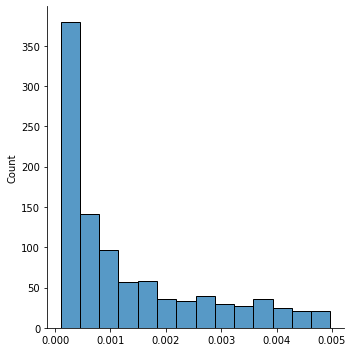

In [15]:
low = np.log(0.0001)
high = np.log(0.005)

sample_size = 1000

sample = np.exp(np.random.uniform(low, high, size=sample_size))

seaborn.displot(sample)
seaborn.despine()

In [16]:
sample.min(), sample.max()

(0.00010024844670163925, 0.004974710817696186)